In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import glob
import datetime
from string import ascii_lowercase as alc

import scipy.stats as stats
from sklearn.model_selection import train_test_split

from pyEDM import *

from libs.funcs import *
### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [7]:
# import datasets
ssta = xr.open_dataset('./data/SST_anoms.nc')
swea = xr.open_dataset('./data/SWE_anoms.nc')

gdf = gpd.read_file('./data/NA_CEC_Eco_Level3/')
wus_eco = gdf[gdf['NA_L3NAME'].isin(eco_regions)]

In [41]:
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree(central_longitude=180)

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
wus_eco = wus_eco.to_crs(crs_proj4)

In [42]:
snotel_pos = swea[['agency', 'siteID', 'latitude', 'longitude', 'elevation']].to_dataframe()
# snotel_pos = snotel_pos.droplevel('sites')

In [43]:
# convert DataFrame to GeoDataFrame
test_gdf = gpd.GeoDataFrame(snotel_pos['agency'],
                            geometry=gpd.points_from_xy(snotel_pos['longitude'],
                                                        snotel_pos['latitude']))

test_gdf.set_crs(crs_proj4, inplace=True)

,agency,geometry
sites,,
0,NRCS,POINT (-120.790 41.240)
1,NRCS,POINT (-112.270 37.520)
2,NRCS,POINT (-111.960 45.600)
3,NRCS,POINT (-150.890 61.750)
4,NRCS,POINT (-121.700 47.780)
...,...,...
1060,AB,POINT (-115.630 55.020)
1061,AB,POINT (-110.494 56.618)
1062,YK,POINT (-135.197 60.522)


In [44]:
test_gdf_w_ecoregions = test_gdf.sjoin(wus_eco, how='inner', predicate='intersects')

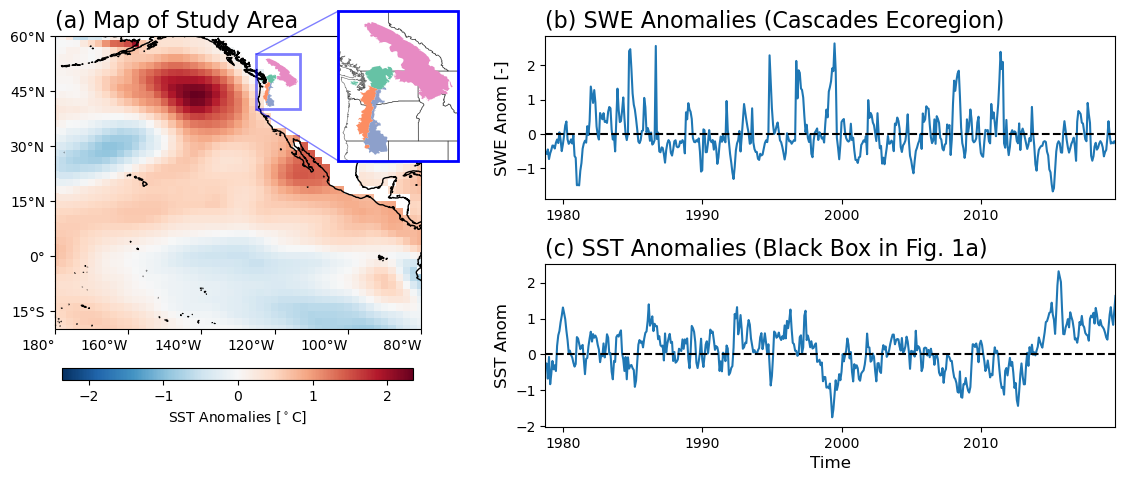

In [45]:
cascades = xr.open_dataset('./data/snow_by_eco/snow_Cascades.nc')
swe_wc = cascades.swe_level2

pnw_eco = gdf[gdf['NA_L3NAME'].isin(coast_ecos)]
pnw_eco = pnw_eco.to_crs(crs_proj4)
pnw_stations = test_gdf.sjoin(pnw_eco, how='inner', predicate='intersects')

# get only Cascades spatial info
gdf_sub = test_gdf_w_ecoregions[test_gdf_w_ecoregions['NA_L3NAME']=='Cascades']

fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(2,3, height_ratios=[0.5,0.5], width_ratios=[1,1,2])
ax = fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())

fig.autofmt_xdate(rotation=0)

ax.coastlines(resolution='50m',
              color='black', linewidth=1)
ax.set_extent([-180, -80, -20, 60], crs=ccrs.PlateCarree())
ax.set_xticks([-180, -160, -140,-120,-100, -80], crs=ccrs.PlateCarree())
ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

cbar_kwargs = {'shrink':0.6, 'aspect':30,
               'label':r'SST Anomalies [$^\circ$C]',
               'orientation':'horizontal', 
               'pad':0.1}

ssta.sst.sel(time='2014-03-01').plot(ax=ax,
                                 transform=ccrs.PlateCarree(),
                                 cbar_kwargs=cbar_kwargs)

rect = Rectangle((222,22),2,2, edgecolor='k', facecolor='none', transform=crs)
ax.add_patch(rect)

# inset ax
inset_ax = fig.add_axes([.24, .65, .3, .3], facecolor='w', projection=ccrs.PlateCarree(),
                        xlim=(236, 220), ylim=(40, 55))
inset_ax.add_feature(cfeature.STATES, alpha=0.5,  lw=0.5)
inset_ax.set_extent([-125, -113, 40, 55], crs=ccrs.PlateCarree())
inset_ax.spines[:].set_color('b')
inset_ax.spines[:].set_linewidth(2)
ax.indicate_inset_zoom(inset_ax, edgecolor="b", lw=2)

c_Pastel1 = ['#fbb4ae','#b3cde3', '#ccebc5', '#decbe4']
c_Set2 = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
for idx, e in enumerate(coast_ecos):
    pnw_eco[pnw_eco['NA_L3NAME']==e].plot(ax=ax, transform=crs, color=c_Set2[idx])
    pnw_eco[pnw_eco['NA_L3NAME']==e].plot(ax=inset_ax, transform=crs, color=c_Set2[idx], zorder=2)
    
ax.set_title('')
ax.set_title('(a) Map of Study Area', loc='left', fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('')


swe_ax = fig.add_subplot(gs[0,2])
swe_wc.mean(dim='sites').plot(ax=swe_ax)
swe_ax.axhline(y=0, color='k', ls='--')
swe_ax.set_ylabel('SWE Anom [-]', fontsize=12)
swe_ax.set_title('(b) SWE Anomalies (Cascades Ecoregion)', loc='left',fontsize=16)
swe_ax.set_xlabel('')
sst_ax = fig.add_subplot(gs[1,2], sharex=swe_ax)
ssta.sst.sel(lon=222, lat=22).plot(ax=sst_ax)
sst_ax.axhline(y=0, color='k', ls='--')
sst_ax.set_ylabel('SST Anom', fontsize=12)
sst_ax.set_xlabel('Time', fontsize=12)
sst_ax.set_title('')
sst_ax.set_title('(c) SST Anomalies (Black Box in Fig. 1a)', loc='left',fontsize=16)

swe_ax.set_xticks(swe_ax.get_xticks()[:-1],
                          swe_ax.get_xticklabels()[:-1], rotation=0, ha='center')
sst_ax.set_xticks(sst_ax.get_xticks()[:-1],
                          sst_ax.get_xticklabels()[:-1], rotation=0, ha='center')
swe_ax.set_xlim([swe_wc.mean(dim='sites').dropna(dim='time').time[0],swe_wc.time[-1]])

plt.tight_layout()
# plt.savefig(pub_folder+'fig1a_1c.eps', bbox_inches='tight', facecolor='w', dpi=100)
plt.show()

In [46]:
### consts
path_to_ccm_results = './data/processed/'
ccm_results_flist = np.sort(glob.glob(path_to_ccm_results+'*.nc'))

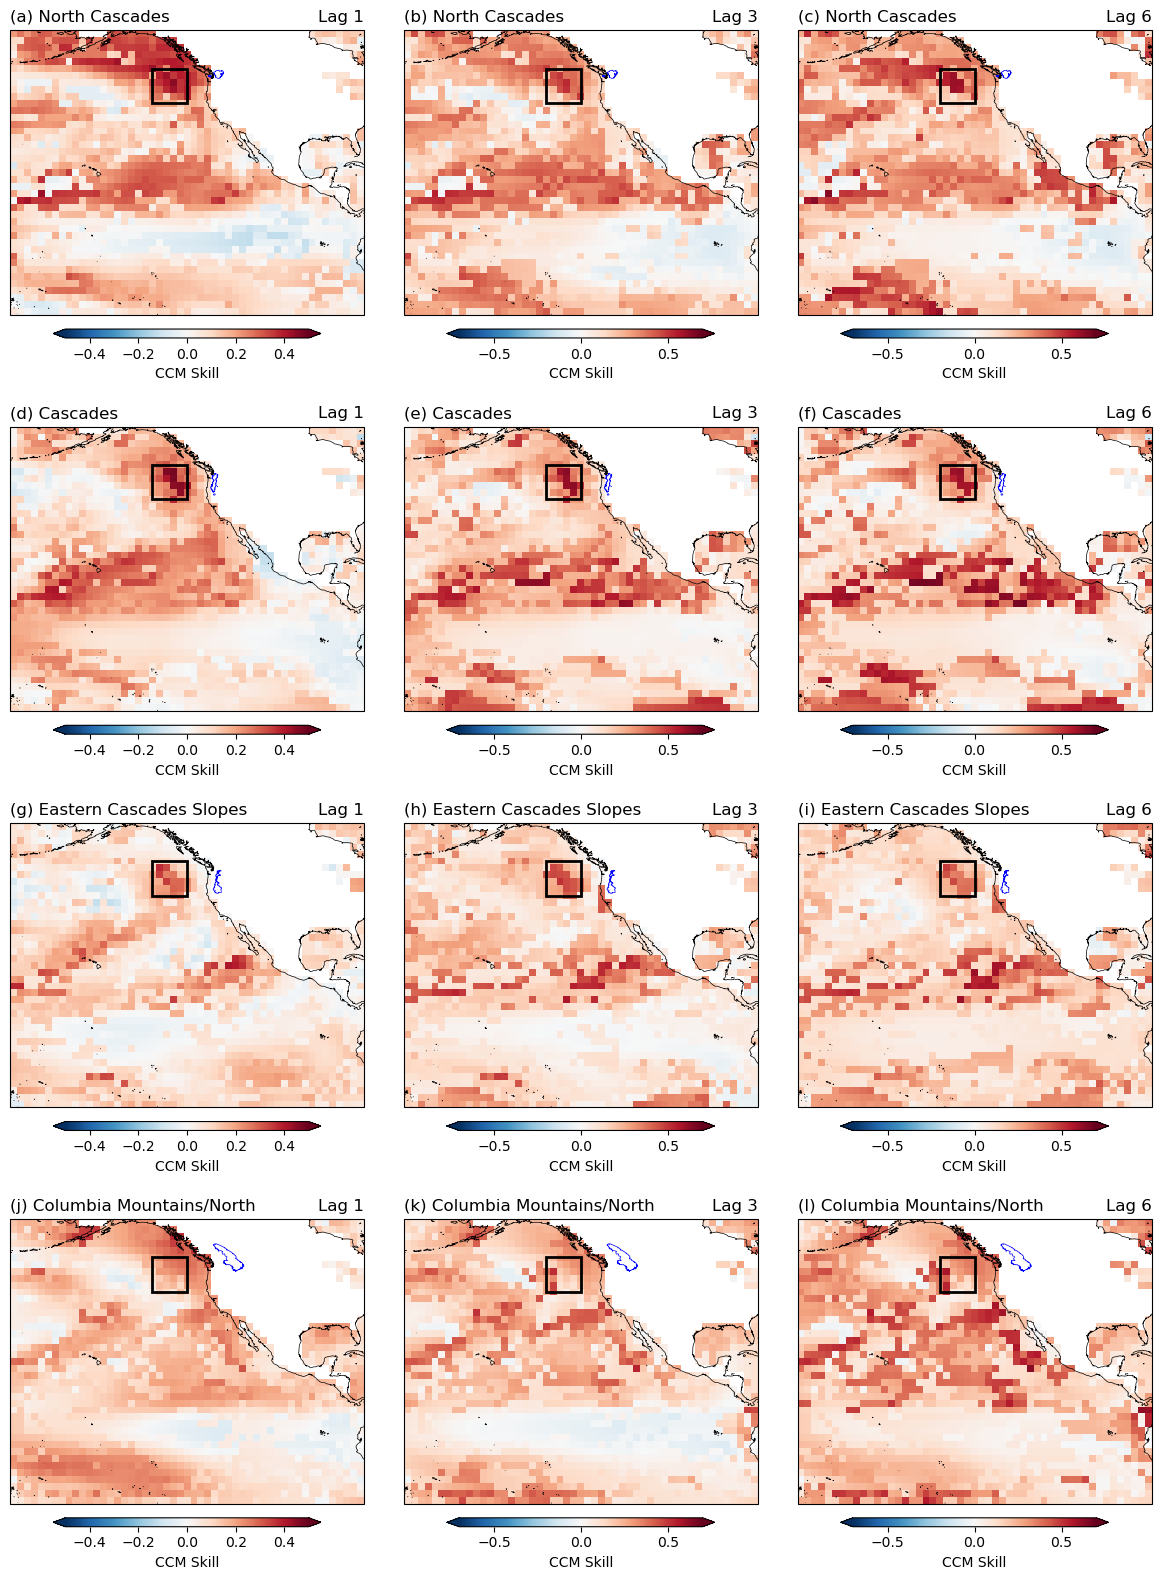

In [47]:
fig = plt.figure(figsize=(12,16))
# create gridspec
gs = fig.add_gridspec(4,3, height_ratios=[1,1,1,1],
                      width_ratios=[1,1,1])

f = ccm_results_flist[3]
lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)

cbar_kwargs = {'shrink':0.7, 'aspect':30,
               'orientation':'horizontal', 'pad':0.04,
               'extend': 'both', 'label': 'CCM Skill'}

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i,0],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.5, vmax=0.5,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[3*i], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)
    
    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')

f = ccm_results_flist[4]
lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i,1],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[3*i+1], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)
    
    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')

f = ccm_results_flist[5]
lag = f.split('_')[3].split('.')[0]
ccm_xr = xr.open_dataset(f)

for i in range(len(coast_ecos)):
    eco_name = str(ccm_xr.sel(eco_region=coast_ecos[i]).eco_region.values)
    sub = wus_eco[wus_eco['NA_L3NAME']==eco_name]
    
    ax = fig.add_subplot(gs[i,2],
                         projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    ccm_xr.sel(eco_region=coast_ecos[i]).rho.plot(ax=ax,
                                       cmap='RdBu_r',
                                       vmin=-0.7, vmax=0.7,
                                       transform=ccrs.PlateCarree(),
                                       cbar_kwargs=cbar_kwargs)
    sub.boundary.plot(ax=ax, color='b', linewidth=0.5)
    ax.set_title('')
    ax.set_title('({}) {:.24s}'.format(alc[3*i+2], eco_name), loc='left', fontsize=12)
    ax.set_title('Lag {}'.format(lag), loc='right', fontsize=12)

    rect = Rectangle((220,40),10,10,
                 edgecolor='k', facecolor='None', transform=ccrs.PlateCarree(), lw=2)
    ax.add_patch(rect)

    # ax.set_xticks([180, 220, 260], crs=ccrs.PlateCarree())
    # ax.set_yticks([-15, 0, 15, 30, 45, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.tight_layout()
# plt.savefig(pub_dir+'fig2a_2l.eps',
#             bbox_inches='tight',
#             facecolor='w')